<br>
<div style="font-size:67px; font-weight:bold; text-align: center;"> Gradient Descent, Demystified </div>
<br>

`whoami`  

`stu`  
Machine Learning Engineer @Opendoor  
@mstewart141  
[comment]: <> (we are *so* hiring)  

# Goal: Puzzle through the gradient descent algorithm towards a working prototype for linear and logistic regression.

Per Wikipedia:
> Gradient descent is a first-order iterative optimization algorithm for finding the __minimum__ of a function. To find a local minimum of a function using gradient descent, one takes steps proportional to the negative of the gradient (or of the approximate gradient) of the function at the current point

## Ok, but what is a gradient?

Per Khan Academy:
> The gradient stores all the partial derivative information of a multivariable function.
  
The gradient is a vector-valued function: a vector of partial derivates.

![title](gd.png)
source: [Wikipedia](https://en.wikipedia.org/wiki/Gradient_descent)

In [2]:
%matplotlib inline

import numpy as np
import sympy

from numpy.linalg import inv
from scipy.special import expit
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.datasets import make_classification
from sympy import diff
from sympy.solvers import solve
from sympy.plotting import plot
from toolz import compose, pipe

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

np.random.seed = RS = 47

## Let's look at an example

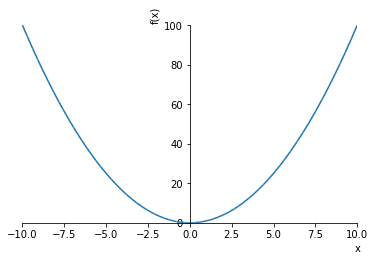

In [3]:
e = 'x*x'
plot(e);

In [4]:
diff(e)

2*x

In [5]:
gradient = np.array(['2x'])

In [6]:
solve(e)

[0]

### You told us to "step proportional to the negative of the gradient"?

what if `x > 0`, `x < 0`?

# Now, we'll do gradient descent live

## Starting with linear regression

In [7]:
X, Y = make_classification(n_samples=1000, n_features=3, n_informative=3,
                           n_redundant=0, n_repeated=0, n_classes=2, 
                           random_state=RS)

#### We need to introduce a `bias` term:

In [8]:
bias_column = np.ones(X.shape[0])

X = np.c_[bias_column, X]
Y = Y.ravel()

### Aside: do we even need gradient descent?

# $$X_{m \times n}, Y_{m \times 1}$$

### Meet the `'normal'` equation:

# $$\begin{equation}y_{mx1} = X_{m \times n}\space\beta_{n \times 1} + \epsilon_{m \times 1}\end{equation}$$
# $$\begin{equation}\beta_{n \times 1} = (X^{T}X)^{-1}_{n \times n}\space X^{T}_{n \times m}\space Y_{m \times 1}\end{equation}$$

#### This gives us a way to compute our `beta` vector:

In [9]:
betas_normal_eq = inv(X.T @ X) @ X.T @ Y

## Sanity check: Scikit-learn

In [11]:
linreg = LinearRegression(fit_intercept=False)
linreg.fit(X,Y);

In [12]:
betas_sklearn = linreg.coef_

In [13]:
betas_normal_eq
betas_sklearn

array([ 0.45801758,  0.27764882, -0.10227603, -0.04232889])

array([ 0.45801758,  0.27764882, -0.10227603, -0.04232889])

## But where are the gradients???

### Spoiler: linear and logistic regression aren't so different to optimize

#### To implement gradient descent for linear regression, we will use the identity function.  
  
#### For logistic regression, we will use the `sigmoid` function:

# $$\begin{equation} F(z) = z \end{equation}$$

# $$\begin{equation} F(z) = \dfrac{1}{1+e^{-z}} \end{equation}$$

### These two functions, let's write 'em up

In [14]:
identity = lambda z: z

sigmoid = expit

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

### Why do these $F(z)$ equations matter? What is our hypothesis?

#### Our two hypotheses will be identical, except for the aforementioned functions!

#### Recall the normal equation?

In [16]:
hypothesis = X @ betas_sklearn
hypothesis_shape = hypothesis.shape

hypothesis_shape

(1000,)

## Gradient Descent!

> Gradient descent is a first-order iterative optimization algorithm

We must define an update step that moves us closer to the solution each iteration.

In [40]:
def gradient_descent(X=X, Y=Y, kind='linear', learning_rate=0.01, iterations=int(1e5)):
    betas = np.zeros(X.shape[1])
    assert kind in {'linear', 'logistic'}, f"Whoops! Don't support kind: {kind}."
    fn = identity if kind == 'linear' else sigmoid
    
    def update_step(betas):
        hypothesis = fn(X @ betas)
        loss = hypothesis - Y
        gradient = X.T @ loss * (1 / X.shape[0])
        return betas - learning_rate * gradient
    
    return pipe(betas, *([update_step] * iterations))

In [40]:
# (tweetable version)
def gradient_descent(X=X, Y=Y, kind='linear', lr=0.01, n=int(1e5)):
    return pipe(np.zeros(X.shape[1]), *([
        lambda betas: betas - lr * 
            X.T @ (((identity if kind == 'linear' else sigmoid)(X @ betas)) - Y) * (1 / X.shape[0])
    ] * n))

### Does it work for linear regression?

In [41]:
betas_gd = gradient_descent()

In [42]:
betas_gd
betas_normal_eq
betas_sklearn

array([ 0.45801758,  0.27764882, -0.10227603, -0.04232889])

array([ 0.45801758,  0.27764882, -0.10227603, -0.04232889])

array([ 0.45801758,  0.27764882, -0.10227603, -0.04232889])

### Great! How about for logistic regression?

### What saith Scikit?

In [25]:
logr = LogisticRegression(fit_intercept=False, C=1e18)
logr.fit(X,Y);

In [26]:
betas_logr = logr.coef_[0]
betas_gdl = gradient_descent(kind='logistic')

In [30]:
np.round(betas_logr, 2)
np.round(betas_gdl, 2)

array([-0.13,  3.08, -1.04, -0.41])

array([-0.13,  3.08, -1.04, -0.41])

### Bold claim: we're 90% of the way to a fully formed sklearn estimator!

In [32]:
class GradientDescentClassifierRegressor:
    def __init__(self, kind='linear', learning_rate=0.01, iterations=int(1e5)):
        self.kind = kind
        self.learning_rate = learning_rate
        self.iterations = iterations
    
    def fit(self, X, Y):
        self.coef_ = gradient_descent(
            X,
            Y,
            self.kind,
            self.learning_rate,
            self.iterations,
        )
        return self
    def predict(self, X):
        try:
            getattr(self, 'coef_')  # illustrative
            fn = identity if self.kind == 'linear' else lambda arr: np.round(sigmoid(arr)).astype(int)
            return fn(X @ self.coef_)
        except AttributeError:
            raise RuntimeError('Must fit first!!!')

In [35]:
gdcr = GradientDescentClassifierRegressor(kind='linear')
gdcr.fit(X,Y);

In [36]:
gdcr.predict(X[:10])
linreg.predict(X[:10])

array([ 0.61911337,  0.3343834 ,  0.49442232,  0.5050518 , -0.20501244,
        0.00771493, -0.06387987,  1.02075149,  0.51484657,  0.77049524])

array([ 0.61911337,  0.3343834 ,  0.49442232,  0.5050518 , -0.20501244,
        0.00771493, -0.06387987,  1.02075149,  0.51484657,  0.77049524])

<br>
<div style="font-size:80px; font-weight:bold; text-align: center;"> Questions? </div>
<br>